In [1]:
import os

import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pyro
import pyro.distributions as dist
import zuko
import numpy as np
from tqdm import tqdm
import IPython

sns.set(style="white", context="notebook", palette="deep", color_codes=True)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
base_path = "data/uav_data"
elevator_failure_experiments = [
    "carbonZ_2018-09-11-14-41-51_elevator_failure",
    "carbonZ_2018-09-11-15-05-11_1_elevator_failure",
]
rudder_failure_experiments = [
    "carbonZ_2018-09-11-15-06-34_1_rudder_right_failure",
    "carbonZ_2018-09-11-15-06-34_2_rudder_right_failure",
    # "carbonZ_2018-09-11-15-06-34_3_rudder_left_failure",
]
nominal_experiments = [
    "carbonZ_2018-07-18-16-37-39_1_no_failure",
    "carbonZ_2018-07-30-16-39-00_3_no_failure",
    "carbonZ_2018-09-11-14-16-55_no_failure",
    "carbonZ_2018-09-11-14-41-38_no_failure",
    "carbonZ_2018-09-11-15-05-11_2_no_failure",
    "carbonZ_2018-10-05-14-34-20_1_no_failure",
    "carbonZ_2018-10-05-14-37-22_1_no_failure",
    "carbonZ_2018-10-05-15-52-12_1_no_failure",
    "carbonZ_2018-10-05-15-52-12_2_no_failure",
    "carbonZ_2018-10-18-11-08-24_no_failure",
]
fields = {
    "mavros-local_position-velocity": {
        "field.twist.linear.x": "twist_vx",
        "field.twist.linear.y": "twist_vy",
        "field.twist.linear.z": "twist_vz",
        "field.twist.angular.x": "twist_wx",
        "field.twist.angular.y": "twist_wy",
        "field.twist.angular.z": "twist_wz",
    },
    "mavros-nav_info-pitch": {
        "field.commanded": "pitch_commanded",
        "field.measured": "pitch_measured",
    },
    "mavros-nav_info-roll": {
        "field.commanded": "roll_commanded",
        "field.measured": "roll_measured",
    },
    "mavros-nav_info-yaw": {
        "field.commanded": "yaw_commanded",
        "field.measured": "yaw_measured",
    },
}


def load_data(base_path, experiment_path, fields, dt=0.25):
    # Load all the dfs into a list, remapping columns to the names in field_names
    dfs = []
    for field_name, field_map in fields.items():
        path = os.path.join(
            base_path, experiment_path, experiment_path + "-" + field_name + ".csv"
        )
        df = pd.read_csv(path)
        df.rename(columns=field_map, inplace=True)
        dfs.append(df)

    # Get the min and max times
    min_time = min([df["%time"].min() for df in dfs]) * 1e-9
    max_time = max([df["%time"].max() for df in dfs]) * 1e-9

    # Normalize and resample time
    dt = 0.25
    t = np.arange(0, max_time - min_time, dt)
    normalized_dfs = []
    for df, field_map in zip(dfs, fields.values()):
        sampled_times = df["%time"] * 1e-9 - min_time
        normalized_df = pd.DataFrame(index=t, columns=field_map.values())
        normalized_df.index.name = "Time (s)"

        for field in field_map.values():
            # We have to treat the error status specially, since it's only reported
            # when a failure is occuring (and is implicitly zero otherwise)
            if "status" in field:
                normalized_df[field] = np.interp(t, sampled_times, df[field], left=0)
            else:
                normalized_df[field] = np.interp(t, sampled_times, df[field])

            # Handle angles to unwrap them
            if "roll" in field or "pitch" in field or "yaw" in field:
                normalized_df[field] = np.unwrap(normalized_df[field], period=360)

        normalized_dfs.append(normalized_df)

    # Merge all the dataframes into one
    df = pd.concat(normalized_dfs, axis=1, join="inner")

    return df


# Load the data
nominal_dfs = [
    load_data(os.path.join(base_path, "nominal"), experiment_path, fields, dt=0.25)
    for experiment_path in nominal_experiments
]
elevator_failure_dfs = [
    load_data(
        os.path.join(base_path, "failure"),
        experiment_path,
        fields | {"failure_status-elevator": {"field.data": "elevator_status"}},
        dt=0.25,
    )
    for experiment_path in elevator_failure_experiments
]
rudder_failure_dfs = [
    load_data(
        os.path.join(base_path, "failure"),
        experiment_path,
        fields | {"failure_status-rudder": {"field.data": "rudder_status"}},
        dt=0.25,
    )
    for experiment_path in rudder_failure_experiments
]

# Trim failure data to the period when a failure is occuring
for df in elevator_failure_dfs:
    df.drop(df[df["elevator_status"] == 0].index, inplace=True)

for df in rudder_failure_dfs:
    df.drop(df[df["rudder_status"] == 0].index, inplace=True)


# Convert the list of DFs into couple of lists of tensors
def df_to_tensors(df):
    roll = df["roll_measured"].to_numpy() * np.pi / 180
    pitch = df["pitch_measured"].to_numpy() * np.pi / 180
    yaw = df["yaw_measured"].to_numpy() * np.pi / 180

    roll_desired = df["roll_commanded"].to_numpy() * np.pi / 180
    pitch_desired = df["pitch_commanded"].to_numpy() * np.pi / 180
    yaw_desired = df["yaw_commanded"].to_numpy() * np.pi / 180

    p = df["twist_wx"].to_numpy()
    q = -df["twist_wy"].to_numpy()
    r = -df["twist_wz"].to_numpy()

    states = torch.tensor(
        np.stack([roll, pitch, yaw], axis=1),
        dtype=torch.float32,
        device=device,
    )
    initial_states = states[:-1]
    next_states = states[1:]

    pqrs = torch.tensor(
        np.stack([p, q, r], axis=1),
        dtype=torch.float32,
        device=device,
    )
    pqrs = pqrs[:-1]

    desired_states = torch.tensor(
        np.stack([roll_desired, pitch_desired, yaw_desired], axis=1),
        dtype=torch.float32,
        device=device,
    )
    desired_states = desired_states[:-1]

    return initial_states, next_states, pqrs, desired_states


nominal_data = [df_to_tensors(df) for df in nominal_dfs]
nominal_data = tuple(map(list, zip(*nominal_data)))
(
    nominal_initial_states,
    nominal_next_states,
    nominal_pqrs,
    nominal_commands,
) = nominal_data
nominal_initial_states = torch.cat(nominal_initial_states)
nominal_next_states = torch.cat(nominal_next_states)
nominal_pqrs = torch.cat(nominal_pqrs)
nominal_commands = torch.cat(nominal_commands)

elevator_failure_data = [df_to_tensors(df) for df in elevator_failure_dfs]
elevator_failure_data = tuple(map(list, zip(*elevator_failure_data)))
(
    elevator_failure_initial_states,
    elevator_failure_next_states,
    elevator_failure_pqrs,
    elevator_failure_commands,
) = elevator_failure_data
elevator_failure_initial_states = torch.cat(elevator_failure_initial_states)
elevator_failure_next_states = torch.cat(elevator_failure_next_states)
elevator_failure_pqrs = torch.cat(elevator_failure_pqrs)
elevator_failure_commands = torch.cat(elevator_failure_commands)

rudder_failure_data = [df_to_tensors(df) for df in rudder_failure_dfs]
rudder_failure_data = tuple(map(list, zip(*rudder_failure_data)))
(
    rudder_failure_initial_states,
    rudder_failure_next_states,
    rudder_failure_pqrs,
    rudder_failure_commands,
) = rudder_failure_data
rudder_failure_initial_states = torch.cat(rudder_failure_initial_states)
rudder_failure_next_states = torch.cat(rudder_failure_next_states)
rudder_failure_pqrs = torch.cat(rudder_failure_pqrs)
rudder_failure_commands = torch.cat(rudder_failure_commands)

In [4]:
def model(
    initial_states,
    commands,
    observed_next_states=None,
    observed_pqrs=None,
    observation_noise_scale=1e-1,
    dt=0.25,
):
    """Define a simplified model for the UAV attitude dynamics.

    Args:
        initial_states: N x 3 tensor of initial states (roll, pitch, yaw) for the UAV
        commands: N x 3 tensor of commands (desired roll, pitch, yaw)
        observed_next_states: N x 3 tensor of observed next states (roll, pitch, yaw)
        observed_pqrs: N x 3 tensor of observed angular velocities (p, q, r)
        observation_noise_scale: Scale of the observation noise
        dt: Time step between states
    """
    # Check consistency of batch and time dimensions
    N = initial_states.shape[0]
    assert initial_states.shape == (N, 3)
    assert commands.shape == (N, 3)
    assert observed_next_states is None or observed_next_states.shape == (N, 3)
    assert observed_pqrs is None or observed_pqrs.shape == (N, 3)

    # Use attitude dyamics with state x = [phi, theta, psi] (roll, pitch, yaw)
    # dx/dt = J^-1 * (Ax + Ke + d + eta)
    # where J^-1 is the kinematics, A is the state-to-state transfer matrix, K is the
    # error-to-state transfer matrix, e is the error, d is a constant bias, and eta is
    # Gaussian noise.

    # Sample the matrices from the prior
    A = pyro.sample(
        "A",
        dist.Normal(torch.zeros(3, 3, device=device), torch.ones(3, 3, device=device)),
    )
    K = pyro.sample(
        "K",
        dist.Normal(torch.zeros(3, 3, device=device), torch.ones(3, 3, device=device)),
    )
    d = pyro.sample(
        "d", dist.Normal(torch.zeros(3, device=device), torch.ones(3, device=device))
    ).reshape(3, 1)
    log_noise_strength = pyro.sample(
        "log_noise_strength", dist.Normal(torch.tensor(-2.0, device=device), 1.0)
    )
    noise_strength = torch.exp(log_noise_strength)

    # Compute the next state for each example in the data
    states = initial_states.reshape(-1, 3, 1)
    commands = commands.reshape(-1, 3, 1)
    errors = commands - states

    # Compute the mean velocity based on the system matrices
    pqr_mean = A @ states + K @ errors + d
    noise_dist = (
        dist.Normal(pqr_mean, noise_strength * torch.ones_like(pqr_mean))
        .to_event(2)
        .expand([N])
    )
    pqrs = pyro.sample(
        "pqrs",
        noise_dist,
        obs=observed_pqrs.reshape(-1, 3, 1) if observed_pqrs is not None else None,
    )
    action_noise = pqrs - pqr_mean

    # Construct the kinematic matrix
    roll, pitch = states[:, 0, 0], states[:, 1, 0]
    Jinv = torch.zeros(N, 3, 3, device=device)
    Jinv[:, 0, 0] = 1.0
    Jinv[:, 0, 1] = torch.tan(pitch) * torch.sin(roll)
    Jinv[:, 0, 2] = torch.tan(roll) * torch.cos(pitch)
    Jinv[:, 1, 1] = torch.cos(roll)
    Jinv[:, 1, 2] = -torch.sin(roll)
    Jinv[:, 2, 1] = torch.sin(roll) / torch.cos(pitch)
    Jinv[:, 2, 2] = torch.cos(roll) / torch.cos(pitch)

    # Integrate the change in state
    next_states = states + dt * Jinv @ pqrs
    noise_dist = (
        dist.Normal(next_states, noise_strength * torch.ones_like(next_states))
        .to_event(2)
        .expand([N])
    )
    observed_states = pyro.sample(
        "states",
        noise_dist,
        obs=observed_next_states.reshape(next_states.shape)
        if observed_next_states is not None
        else None,
    )
    state_observation_noise = observed_states - next_states

    return next_states, pqrs, state_observation_noise, action_noise


# Try the model on the nominal data
sim_states, sim_pqrs, sim_obs_noise, sim_action_noise = model(
    initial_states=nominal_initial_states,
    commands=nominal_commands,
    observed_next_states=None,  # nominal_next_states,
    observed_pqrs=None,  # nominal_pqrs,
    observation_noise_scale=1e-1,
    dt=0.25,
)

In [5]:
# Define loss functions
def elbo_loss(model, guide, context, num_particles=10, *model_args, **model_kwargs):
    elbo = torch.tensor(0.0).to(context.device)
    guide_dist = guide(context)
    for _ in range(num_particles):
        posterior_sample, posterior_logprob = guide_dist.rsample_and_log_prob()

        # Parse the sample into the correct shapes
        A = posterior_sample[:9].reshape(3, 3)
        K = posterior_sample[9:18].reshape(3, 3)
        d = posterior_sample[18:21].reshape(3)
        log_noise_strength = posterior_sample[21]

        model_trace = pyro.poutine.trace(
            pyro.poutine.condition(
                model,
                data={
                    "A": A,
                    "K": K,
                    "d": d,
                    "log_noise_strength": log_noise_strength,
                },
            )
        ).get_trace(*model_args, **model_kwargs)
        model_logprob = model_trace.log_prob_sum()

        elbo += (model_logprob - posterior_logprob) / num_particles

    return -elbo  #  negative to make it a loss


def kl_divergence(p, q, p_contexts, q_contexts, num_particles=10):
    # Make sure contexts have a batch dimension
    if p_contexts.ndim == 1:
        p_contexts = p_contexts.unsqueeze(0)

    if q_contexts.ndim == 1:
        q_contexts = q_contexts.unsqueeze(0)

    # Make sure contexts have the same shape
    if p_contexts.shape != q_contexts.shape:
        raise ValueError("Contexts must have the same shape")

    p_dist = p(p_contexts)
    q_dist = q(q_contexts)

    p_samples, p_logprobs = p_dist.rsample_and_log_prob((num_particles,))
    q_logprobs = q_dist.log_prob(p_samples)

    kl_divergence = (p_logprobs - q_logprobs).mean(dim=0)

    return kl_divergence

In [6]:
# Test the ELBO function
with torch.no_grad():
    flow = zuko.flows.NSF(
        features=2 * 3 * 3 + 3 + 1,
        context=1,
        transforms=2,
        hidden_features=(16, 16),
    ).to(device)
    context = torch.tensor([0.0], device=device)
    print(
        elbo_loss(
            model,
            flow,
            context,
            10,
            initial_states=nominal_initial_states,
            commands=nominal_commands,
            observed_next_states=nominal_next_states,
            observed_pqrs=nominal_pqrs,
            dt=0.25,
            observation_noise_scale=1e-1,
        )
    )

tensor(240249.7500, device='cuda:2')


In [7]:
# Test the divergence functions
with torch.no_grad():
    flow1 = zuko.flows.NSF(
        features=2 * 3 * 3 + 3 + 1,
        context=1,
        transforms=2,
        hidden_features=(16, 16),
    ).to(device)
    flow2 = zuko.flows.NSF(
        features=2 * 3 * 3 + 3 + 1,
        context=1,
        transforms=2,
        hidden_features=(16, 16),
    ).to(device)
    context = torch.zeros((20, 1), device=device)
    %time kl_divergence(flow1, flow2, context, context, num_particles=25 * 40)

CPU times: user 674 ms, sys: 419 ms, total: 1.09 s
Wall time: 796 ms


In [8]:
# Define hyperparams
num_steps = 1000
lr = 1e-2
lr_gamma = 0.1
lr_steps = 250
grad_clip = 10
weight_decay = 1e-4
num_elbo_particles = 10
num_divergence_particles = 10
num_divergence_points = 40
divergence_weight = 1.0
observation_noise_scale = 0.1
elbo_weight = 1e1

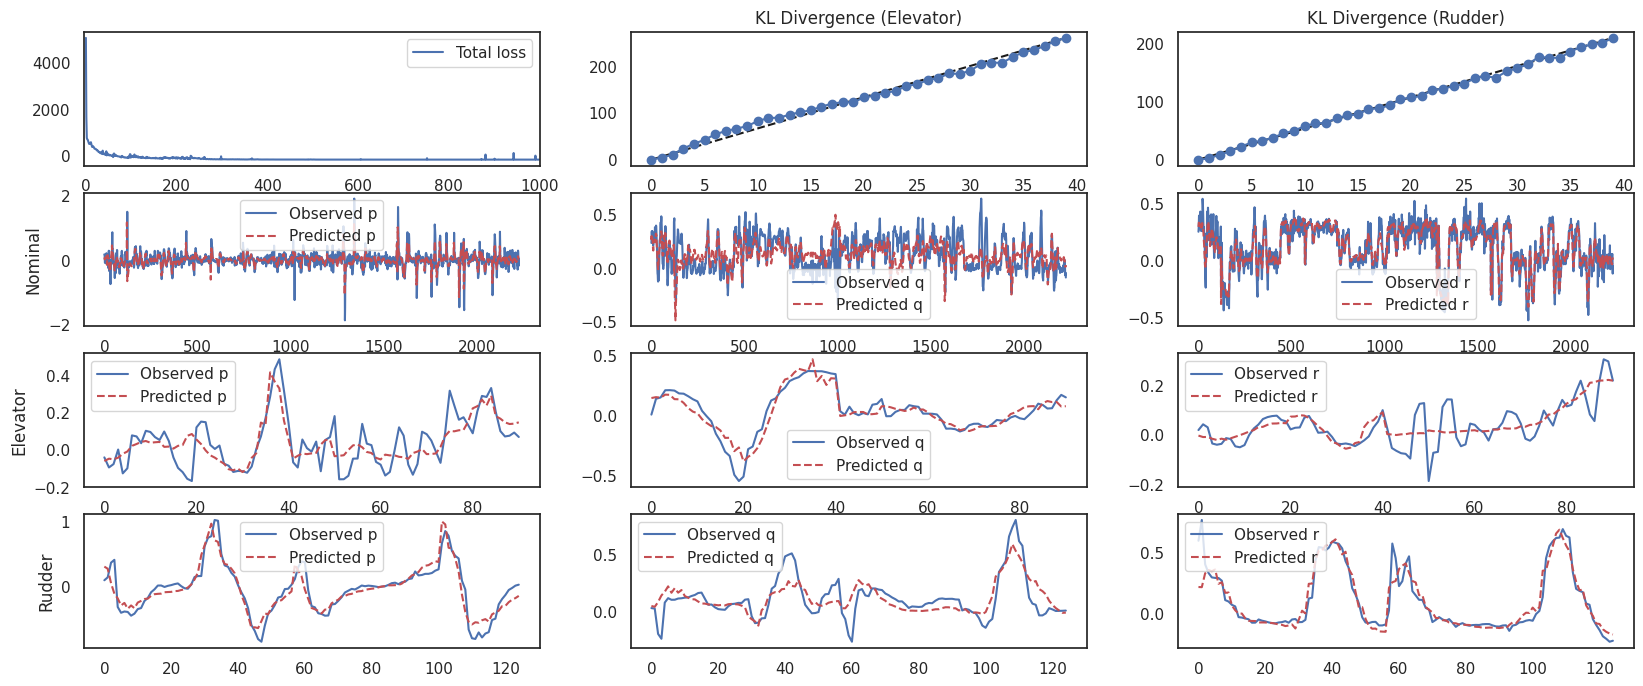

Step 999 | Nominal ELBO: -1.027e+04 | Elevator failure ELBO: -6.706e+02 | Rudder failure ELBO: -5.884e+02 | Rudder failure divergence: 3.305e-03 |Elevator failure divergence: 1.459e-02 |Loss: -1.669e+02 | Grad norm: 2.510e+02: 100%|██████████| 1000/1000 [2:34:15<00:00,  9.26s/it]


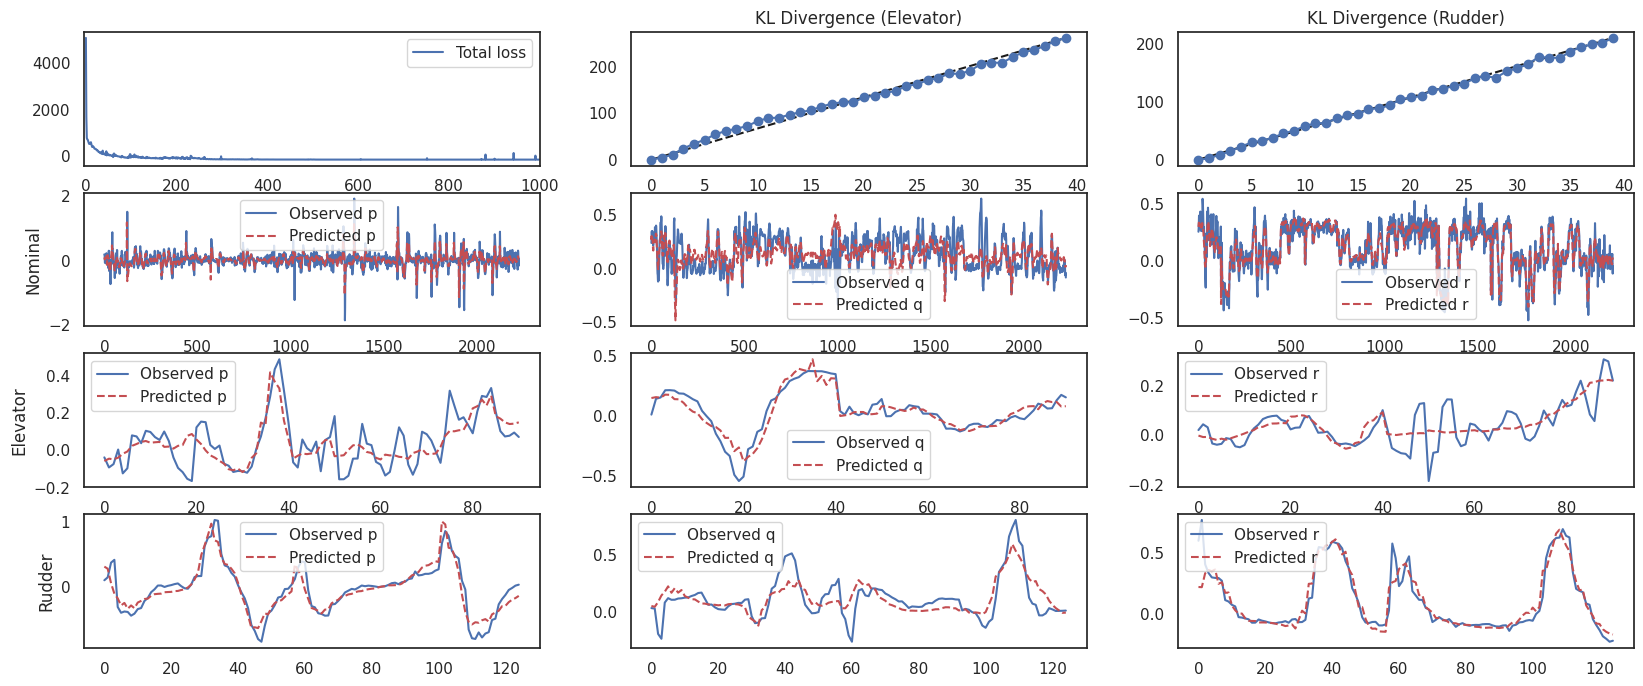

In [9]:
# Fit a combined nominal and failure posterior using a normalizing flow
flow = zuko.flows.NSF(features=2 * 3 * 3 + 3 + 1, context=2).to(device)

optim = torch.optim.Adam(flow.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=lr_steps, gamma=lr_gamma)
nominal_elbo_losses = []
elevator_failure_elbo_losses = []
rudder_failure_elbo_losses = []
divergence_losses = []
total_losses = []

nominal_label = torch.tensor([0.0, 0.0], device=device)
elevator_failure_label = torch.tensor([1.0, 0.0], device=device)
rudder_failure_label = torch.tensor([0.0, 1.0], device=device)
divergence_bounds = torch.linspace(0.0, 1.0, num_divergence_points).to(device)
elevator_divergence_bounds = torch.vstack(
    [divergence_bounds, torch.zeros_like(divergence_bounds)]
).T
rudder_divergence_bounds = torch.vstack(
    [torch.zeros_like(divergence_bounds), divergence_bounds]
).T
nominal_context = torch.tensor([[0.0, 0.0]] * num_divergence_points).to(device)

N_nominal = nominal_initial_states.shape[0]
N_elevator_failure = elevator_failure_initial_states.shape[0]
N_rudder_failure = rudder_failure_initial_states.shape[0]

print(
    f"Training with {N_nominal} nominal examples, {N_elevator_failure} elevator failure examples, and {N_rudder_failure} rudder failure examples"
)

pbar = tqdm(range(num_steps))
for step in pbar:
    # TODO do we need minibatches here?

    optim.zero_grad()

    # Compute the loss components
    loss_components = {
        "nominal_elbo": elbo_loss(
            model,
            flow,
            nominal_label,
            num_elbo_particles,
            initial_states=nominal_initial_states,
            commands=nominal_commands,
            observed_next_states=nominal_next_states,
            observed_pqrs=nominal_pqrs,
            dt=0.25,
            observation_noise_scale=1e-1,
        ),
        "elevator_failure_elbo": elbo_loss(
            model,
            flow,
            elevator_failure_label,
            num_elbo_particles,
            initial_states=elevator_failure_initial_states,
            commands=elevator_failure_commands,
            observed_next_states=elevator_failure_next_states,
            observed_pqrs=elevator_failure_pqrs,
            dt=0.25,
            observation_noise_scale=1e-1,
        ),
        "rudder_failure_elbo": elbo_loss(
            model,
            flow,
            rudder_failure_label,
            num_elbo_particles,
            initial_states=rudder_failure_initial_states,
            commands=rudder_failure_commands,
            observed_next_states=rudder_failure_next_states,
            observed_pqrs=rudder_failure_pqrs,
            dt=0.25,
            observation_noise_scale=1e-1,
        ),
        "elevator_divergence": kl_divergence(
            flow,
            flow,
            nominal_context,
            elevator_divergence_bounds,
            num_divergence_particles,
        ),
        "rudder_divergence": kl_divergence(
            flow,
            flow,
            nominal_context,
            rudder_divergence_bounds,
            num_divergence_particles,
        ),
    }
    # Re-scale the divergence to [0, 1] (since we're using unbounded KL divergence)
    # Use the divergence at label=1 as the reference point
    elevator_failure_divergence = loss_components["elevator_divergence"][-1].clone()
    loss_components["elevator_divergence"] /= elevator_failure_divergence + 1e-3
    rudder_failure_divergence = loss_components["rudder_divergence"][-1].clone()
    loss_components["rudder_divergence"] /= rudder_failure_divergence + 1e-3

    # Compute the loss based on the elbo and the deviation from divergence bounds
    loss_components["elevator_divergence_deviation"] = torch.nn.functional.relu(
        loss_components["elevator_divergence"] - divergence_bounds
    ).mean()
    loss_components["rudder_divergence_deviation"] = torch.nn.functional.relu(
        loss_components["rudder_divergence"] - divergence_bounds
    ).mean()
    loss = (
        elbo_weight * loss_components["nominal_elbo"] / N_nominal
        + elbo_weight * loss_components["elevator_failure_elbo"] / N_elevator_failure
        + elbo_weight * loss_components["rudder_failure_elbo"] / N_rudder_failure
        + divergence_weight * loss_components["elevator_divergence_deviation"]
        + divergence_weight * loss_components["rudder_divergence_deviation"]
    )

    # Step the optimizer
    loss.backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(flow.parameters(), grad_clip)
    optim.step()
    scheduler.step()

    # Record the losses
    nominal_elbo_losses.append(loss_components["nominal_elbo"].detach().cpu().item())
    elevator_failure_elbo_losses.append(
        loss_components["elevator_failure_elbo"].detach().cpu().item()
    )
    rudder_failure_elbo_losses.append(
        loss_components["rudder_failure_elbo"].detach().cpu().item()
    )
    divergence_losses.append(
        loss_components["elevator_divergence_deviation"].detach().cpu().item()
        + loss_components["rudder_divergence_deviation"].detach().cpu().item()
    )
    total_losses.append(loss.detach().cpu().item())

    pbar.set_description(
        f"Step {step} | "
        f"Nominal ELBO: {nominal_elbo_losses[-1]:.3e} | "
        f"Elevator failure ELBO: {elevator_failure_elbo_losses[-1]:.3e} | "
        f"Rudder failure ELBO: {rudder_failure_elbo_losses[-1]:.3e} | "
        f"Rudder failure divergence: {loss_components['rudder_divergence_deviation']:.3e} |"
        f"Elevator failure divergence: {loss_components['elevator_divergence_deviation']:.3e} |"
        f"Loss: {total_losses[-1]:.3e} | "
        f"Grad norm: {grad_norm:.3e}"
    )

    # Plot the progress
    plt.close()
    IPython.display.clear_output(wait=True)
    fig, axs = plt.subplots(4, 3, figsize=(20, 8))
    axs[0, 0].plot(total_losses, label="Total loss")
    axs[0, 0].set_xlim(-5, num_steps)
    axs[0, 0].legend()

    axs[0, 1].plot(
        divergence_bounds.cpu() * elevator_failure_divergence.detach().cpu(),
        "k--",
        label="Bound",
    )
    axs[0, 1].plot(
        loss_components["elevator_divergence"].detach().cpu()
        * elevator_failure_divergence.detach().cpu(),
        "b-o",
        label="Observed",
    )
    axs[0, 1].set_title("KL Divergence (Elevator)")

    axs[0, 2].plot(
        divergence_bounds.cpu() * rudder_failure_divergence.detach().cpu(),
        "k--",
        label="Bound",
    )
    axs[0, 2].plot(
        loss_components["rudder_divergence"].detach().cpu()
        * rudder_failure_divergence.detach().cpu(),
        "b-o",
        label="Observed",
    )
    axs[0, 2].set_title("KL Divergence (Rudder)")

    # See how well we predict the dynamics (the mapping from PQR and current state to
    # next state is known and deterministic, so we just need to compare the predicted
    # PQR to the observed PQR)
    with torch.no_grad():
        # Nominal
        posterior_sample = flow(nominal_label).sample((100,)).mean(dim=0)
        A = posterior_sample[:9].reshape(3, 3)
        K = posterior_sample[9:18].reshape(3, 3)
        d = posterior_sample[18:21].reshape(3, 1)
        states = nominal_initial_states.reshape(-1, 3, 1)
        commands = nominal_commands.reshape(-1, 3, 1)
        errors = commands - states
        nominal_pqr_predicted = A @ states + K @ errors + d

        # Elevator failure
        posterior_sample = flow(elevator_failure_label).sample((100,)).mean(dim=0)
        A = posterior_sample[:9].reshape(3, 3)
        K = posterior_sample[9:18].reshape(3, 3)
        d = posterior_sample[18:21].reshape(3, 1)
        states = elevator_failure_initial_states.reshape(-1, 3, 1)
        commands = elevator_failure_commands.reshape(-1, 3, 1)
        errors = commands - states
        elevator_failure_pqr_predicted = A @ states + K @ errors + d

        # Rudder failure
        posterior_sample = flow(rudder_failure_label).sample((100,)).mean(dim=0)
        A = posterior_sample[:9].reshape(3, 3)
        K = posterior_sample[9:18].reshape(3, 3)
        d = posterior_sample[18:21].reshape(3, 1)
        states = rudder_failure_initial_states.reshape(-1, 3, 1)
        commands = rudder_failure_commands.reshape(-1, 3, 1)
        errors = commands - states
        rudder_failure_pqr_predicted = A @ states + K @ errors + d

    for row_i in [0, 1, 2]:
        pqr_obs = [
            nominal_pqrs,
            elevator_failure_pqrs,
            rudder_failure_pqrs,
        ][row_i].detach().cpu()
        pqr_pred = [
            nominal_pqr_predicted,
            elevator_failure_pqr_predicted,
            rudder_failure_pqr_predicted,
        ][row_i].detach().cpu()

        for pqr_i in [0, 1, 2]:
            var = ["p", "q", "r"][pqr_i]
            axs[1 + row_i, pqr_i].plot(pqr_obs[:, pqr_i], "b-", label="Observed " + var)
            axs[1 + row_i, pqr_i].plot(pqr_pred[:, pqr_i], "r--", label="Predicted " + var)
            
            axs[1 + row_i, pqr_i].legend()

        axs[1 + row_i, 0].set_ylabel(["Nominal", "Elevator", "Rudder"][row_i])

    IPython.display.display(plt.gcf())

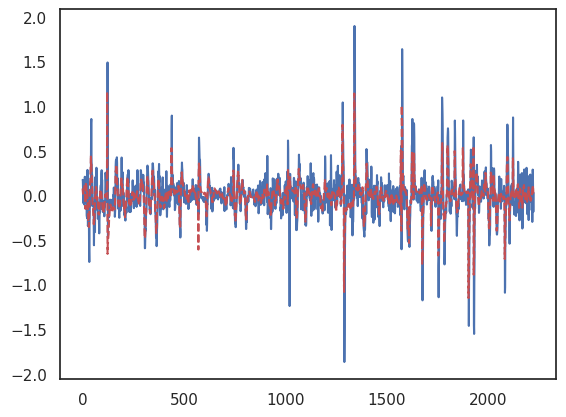

In [10]:
plt.plot(nominal_pqrs[:, 0].detach().cpu(), "b-", label="Observed p")
plt.plot(nominal_pqr_predicted[:, 0].detach().cpu(), "r--", label="Predicted p")